In [4]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
# import tensorflow as tf
# tf.VERSION

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

load data

In [63]:
tmp = np.load("X.npy")
X = np.zeros((tmp.shape[0], tmp.shape[1], tmp.shape[2], 1))
X[:,:,:,0] = np.load("X.npy")
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


NameError: name 'y' is not defined

In [71]:
X.shape

(9090, 100, 100, 1)

kmeans clustering

In [114]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(X.reshape([X.shape[0],-1]))

In [117]:
y = kmeans.labels_
n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# one hot
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# model definition
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(100,100,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# training
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()
batch_size = 32
epochs = 2
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               18874496  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [5]:
ypred = model.predict_classes(X)


NameError: name 'model' is not defined

In [120]:
model2 = model
model2

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(18,4))

sns.scatterplot(y_data[:,0], y_data[:,1], hue = y, palette="Set2", ax=ax[0])
ax[0].set_xlabel('spin')
ax[0].set_ylabel('incl')
ax[0].set_title('true')

sns.scatterplot(y_data[:,0], y_data[:,1], hue = ypred, palette="Set2", ax=ax[1])
ax[1].set_xlabel('spin')
ax[1].set_ylabel('incl')
ax[1].set_title('predicted')

sns.scatterplot(y_data[y!=ypred,0], y_data[y!=ypred,1], 
                hue = ypred[y!=ypred], palette="Set2", ax=ax[2])
ax[2].set_xlabel('spin')
ax[2].set_ylabel('incl')
ax[2].set_title('misclassified points')

In [12]:
# Save the model
model_yaml = model.to_yaml()
with open("kmeans_cnn_incl_spin.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("kmeans_cnn_incl_spin_weights.h5")
yaml_file.close()

In [10]:
# Load the model
yaml_file = open('kmeans_cnn_incl_spin.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = keras.models.model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("kmeans_cnn_incl_spin_weights.h5")

In [ ]:
#make prediction using loaded model
X = np.zeros((X_data.shape[0], X_data.shape[1], X_data.shape[2], 1))
X[:,:,:,0] = X_data
ypred = loaded_model.predict_classes(X)

In [7]:
# import pkg_resources
# pkg_resources.require("scipy==1.1.0")
# import twisted
import scipy
scipy.__version__
# conda 

'1.1.0'

In [13]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from vis.input_modifiers import Jitter
%matplotlib inline
plt.rcParams['figure.figsize'] = (40, 40)

# Swap softmax with linear
loaded_model.layers[-1].activation = activations.linear
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
#Save and then reload to reload graph
loaded_model.save('~/2_iter_model/o')
model3 = keras.models.load_model('~/2_iter_model/o')


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

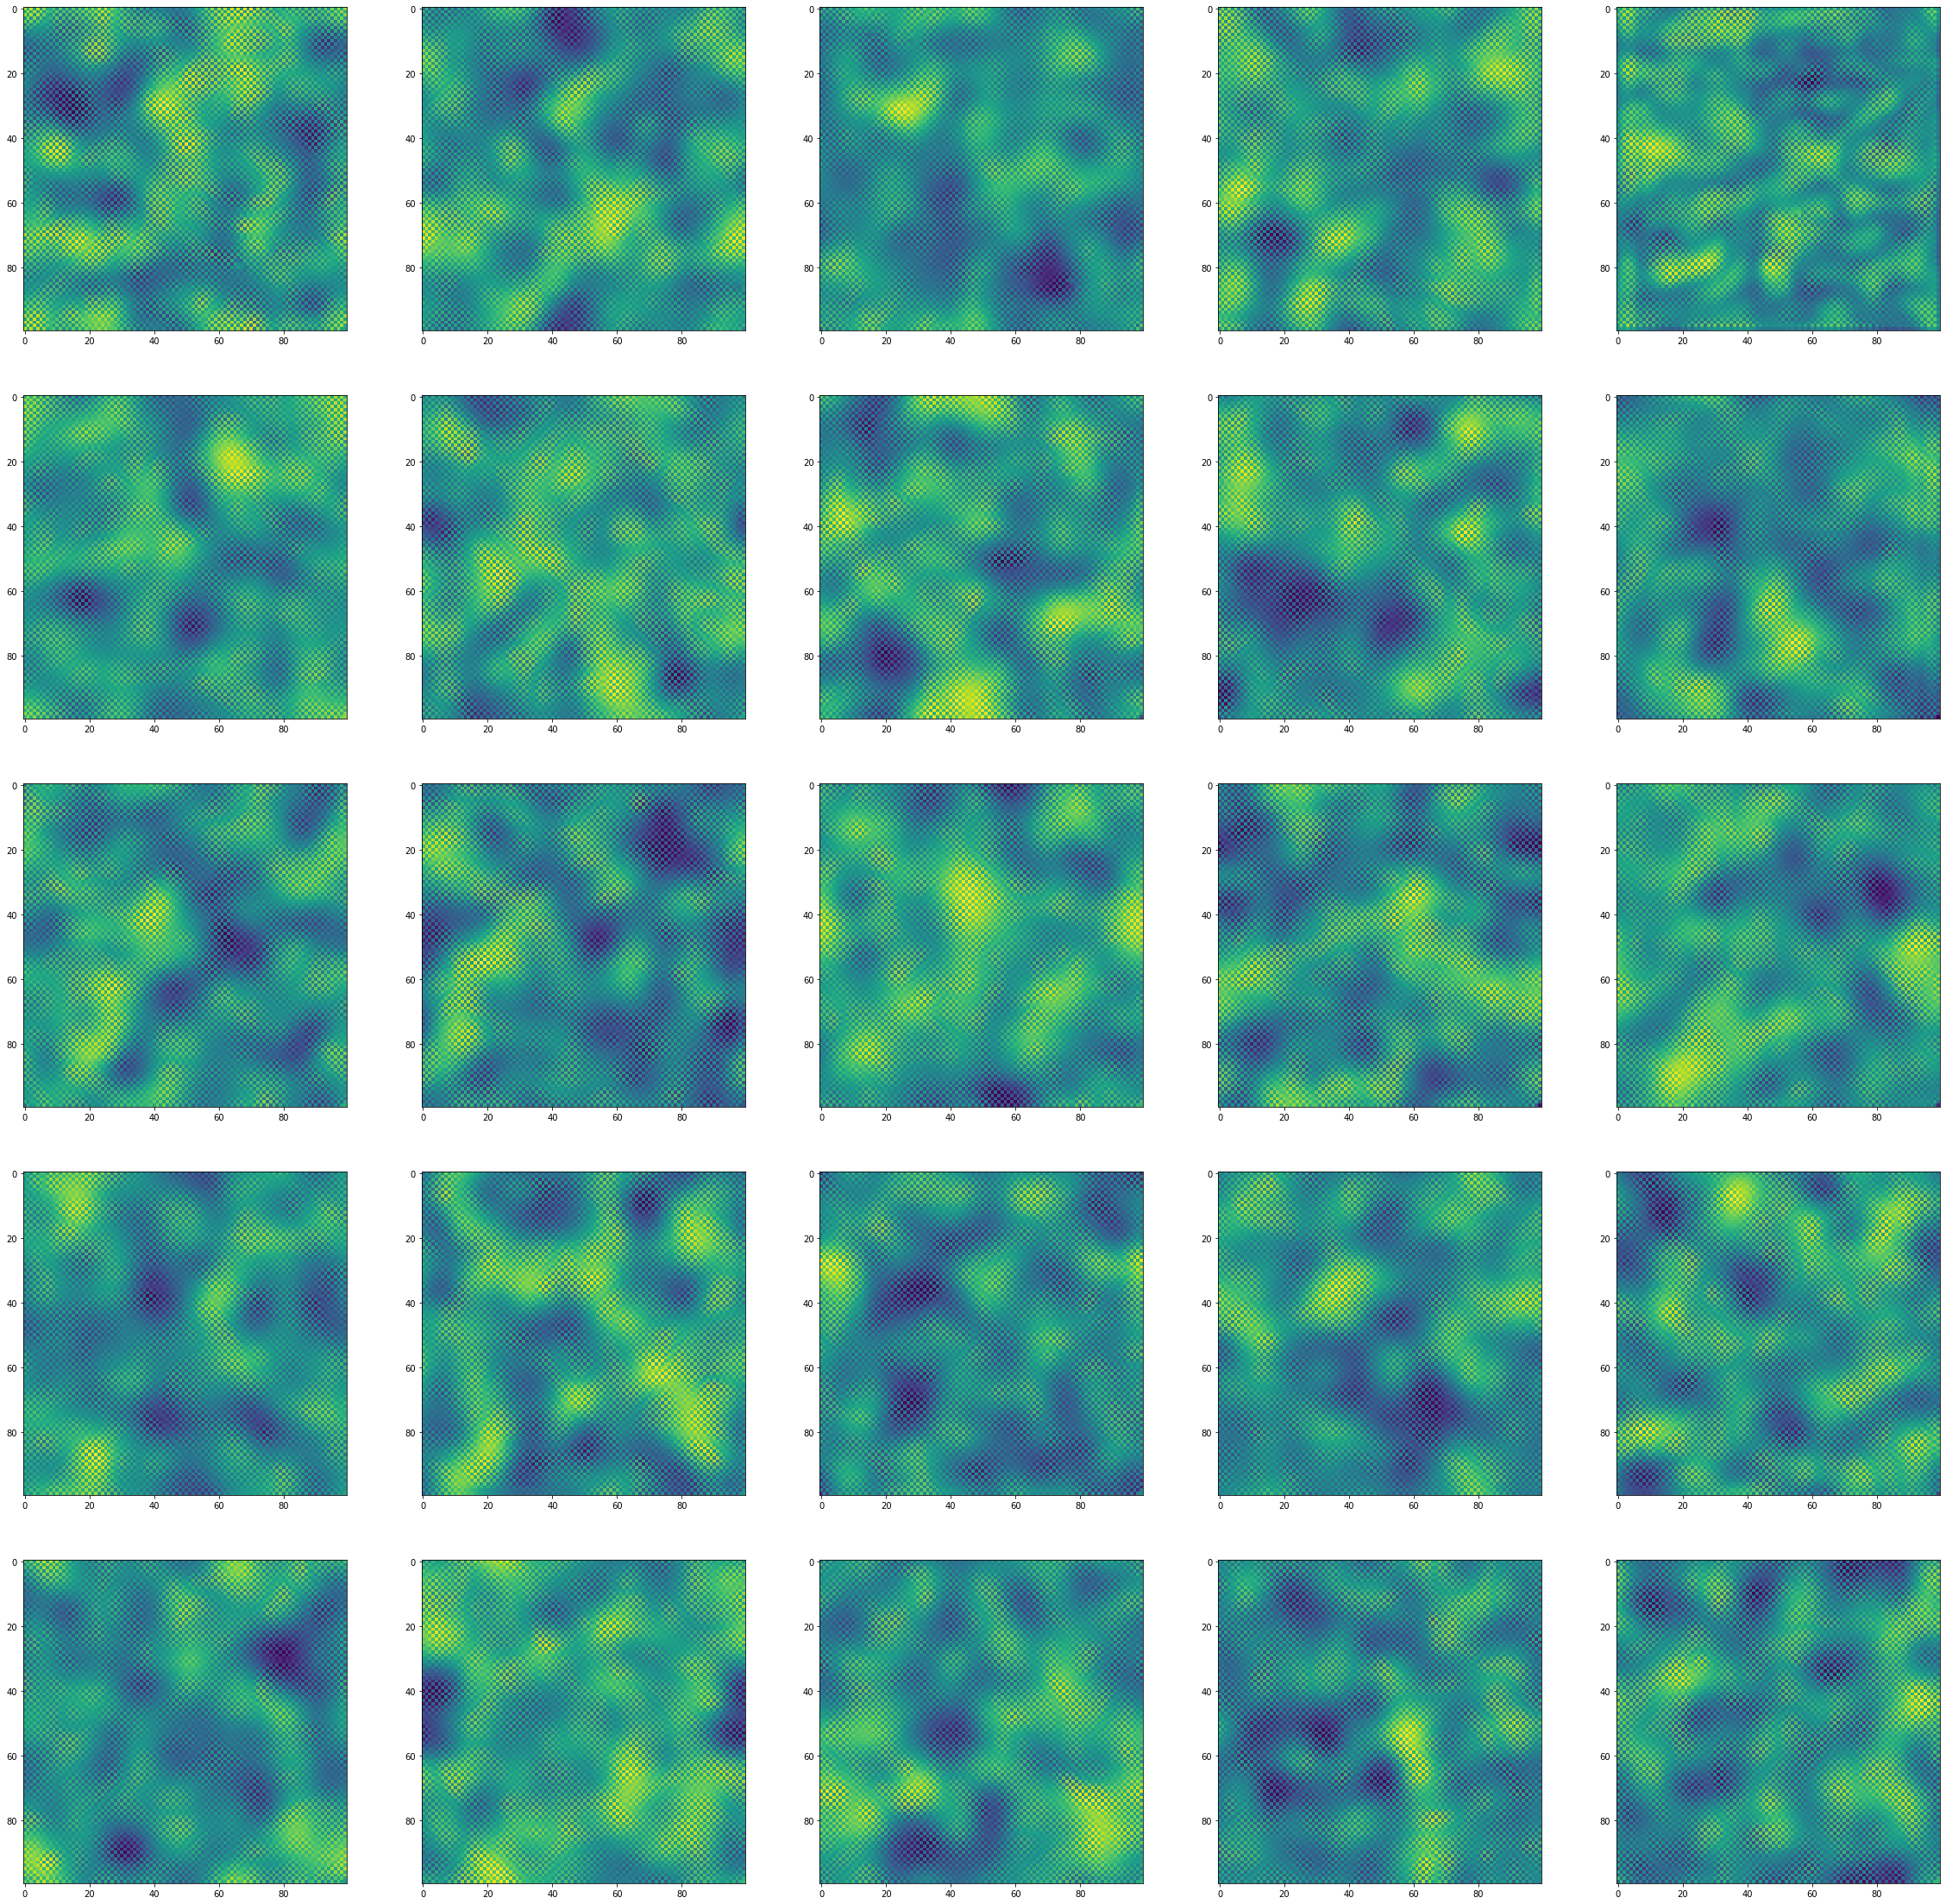

In [90]:
weights = [1e-3, 1e-2, 1e-1, 1, 10]
for i, tv_weight in enumerate(weights):
    for j, l_weight in enumerate(weights):
        ax1=plt.subplot(5, 5, (5*i + j)+1)
        img = visualize_activation(model3, -1, filter_indices=filter_idx, max_iter = 60, input_modifiers=[Jitter(16)], tv_weight=tv_weight, lp_norm_weight=l_weight)
        ax1.imshow(img[..., 0])

#     ax1.show()
plt.colorbar()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

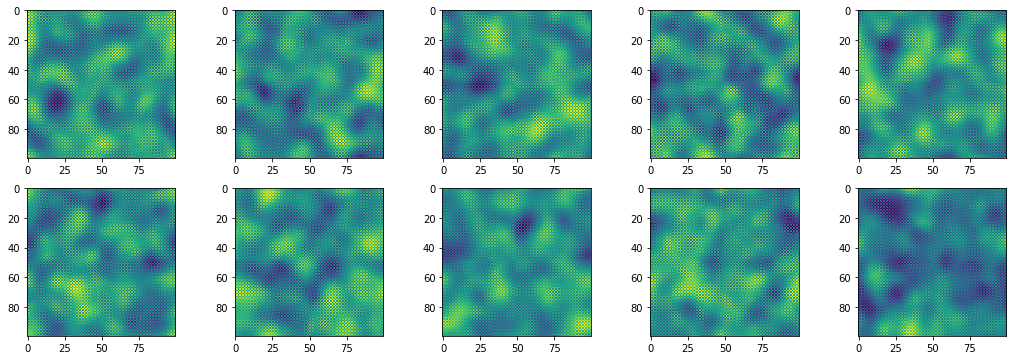

In [56]:
for filter_idx in range(10):
    ax1=plt.subplot(2, 5, filter_idx + 1)
    img = visualize_activation(model3, -1, filter_indices=filter_idx, max_iter = 60, input_modifiers=[Jitter(16)])
    ax1.imshow(img[..., 0])

#     ax1.show()
plt.colorbar()


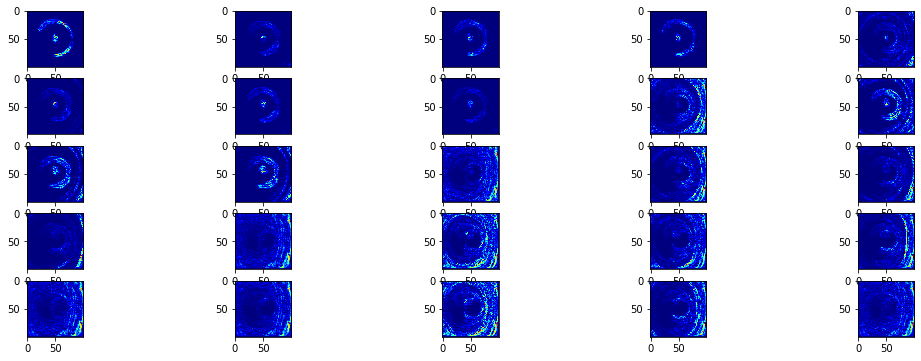

In [80]:
from vis.visualization import visualize_saliency
plt.rcParams['figure.figsize'] = (40, 40)

idxs = [int(x) for x in np.linspace(0,9089, 25)]
for i, seed_idx in enumerate(idxs):
    ax1=plt.subplot(5, 5, i+1)
    grads = visualize_saliency(model3, -1, filter_indices=0, seed_input=X[seed_idx])
    ax1.imshow(grads, cmap='jet')
#     ax1.show()

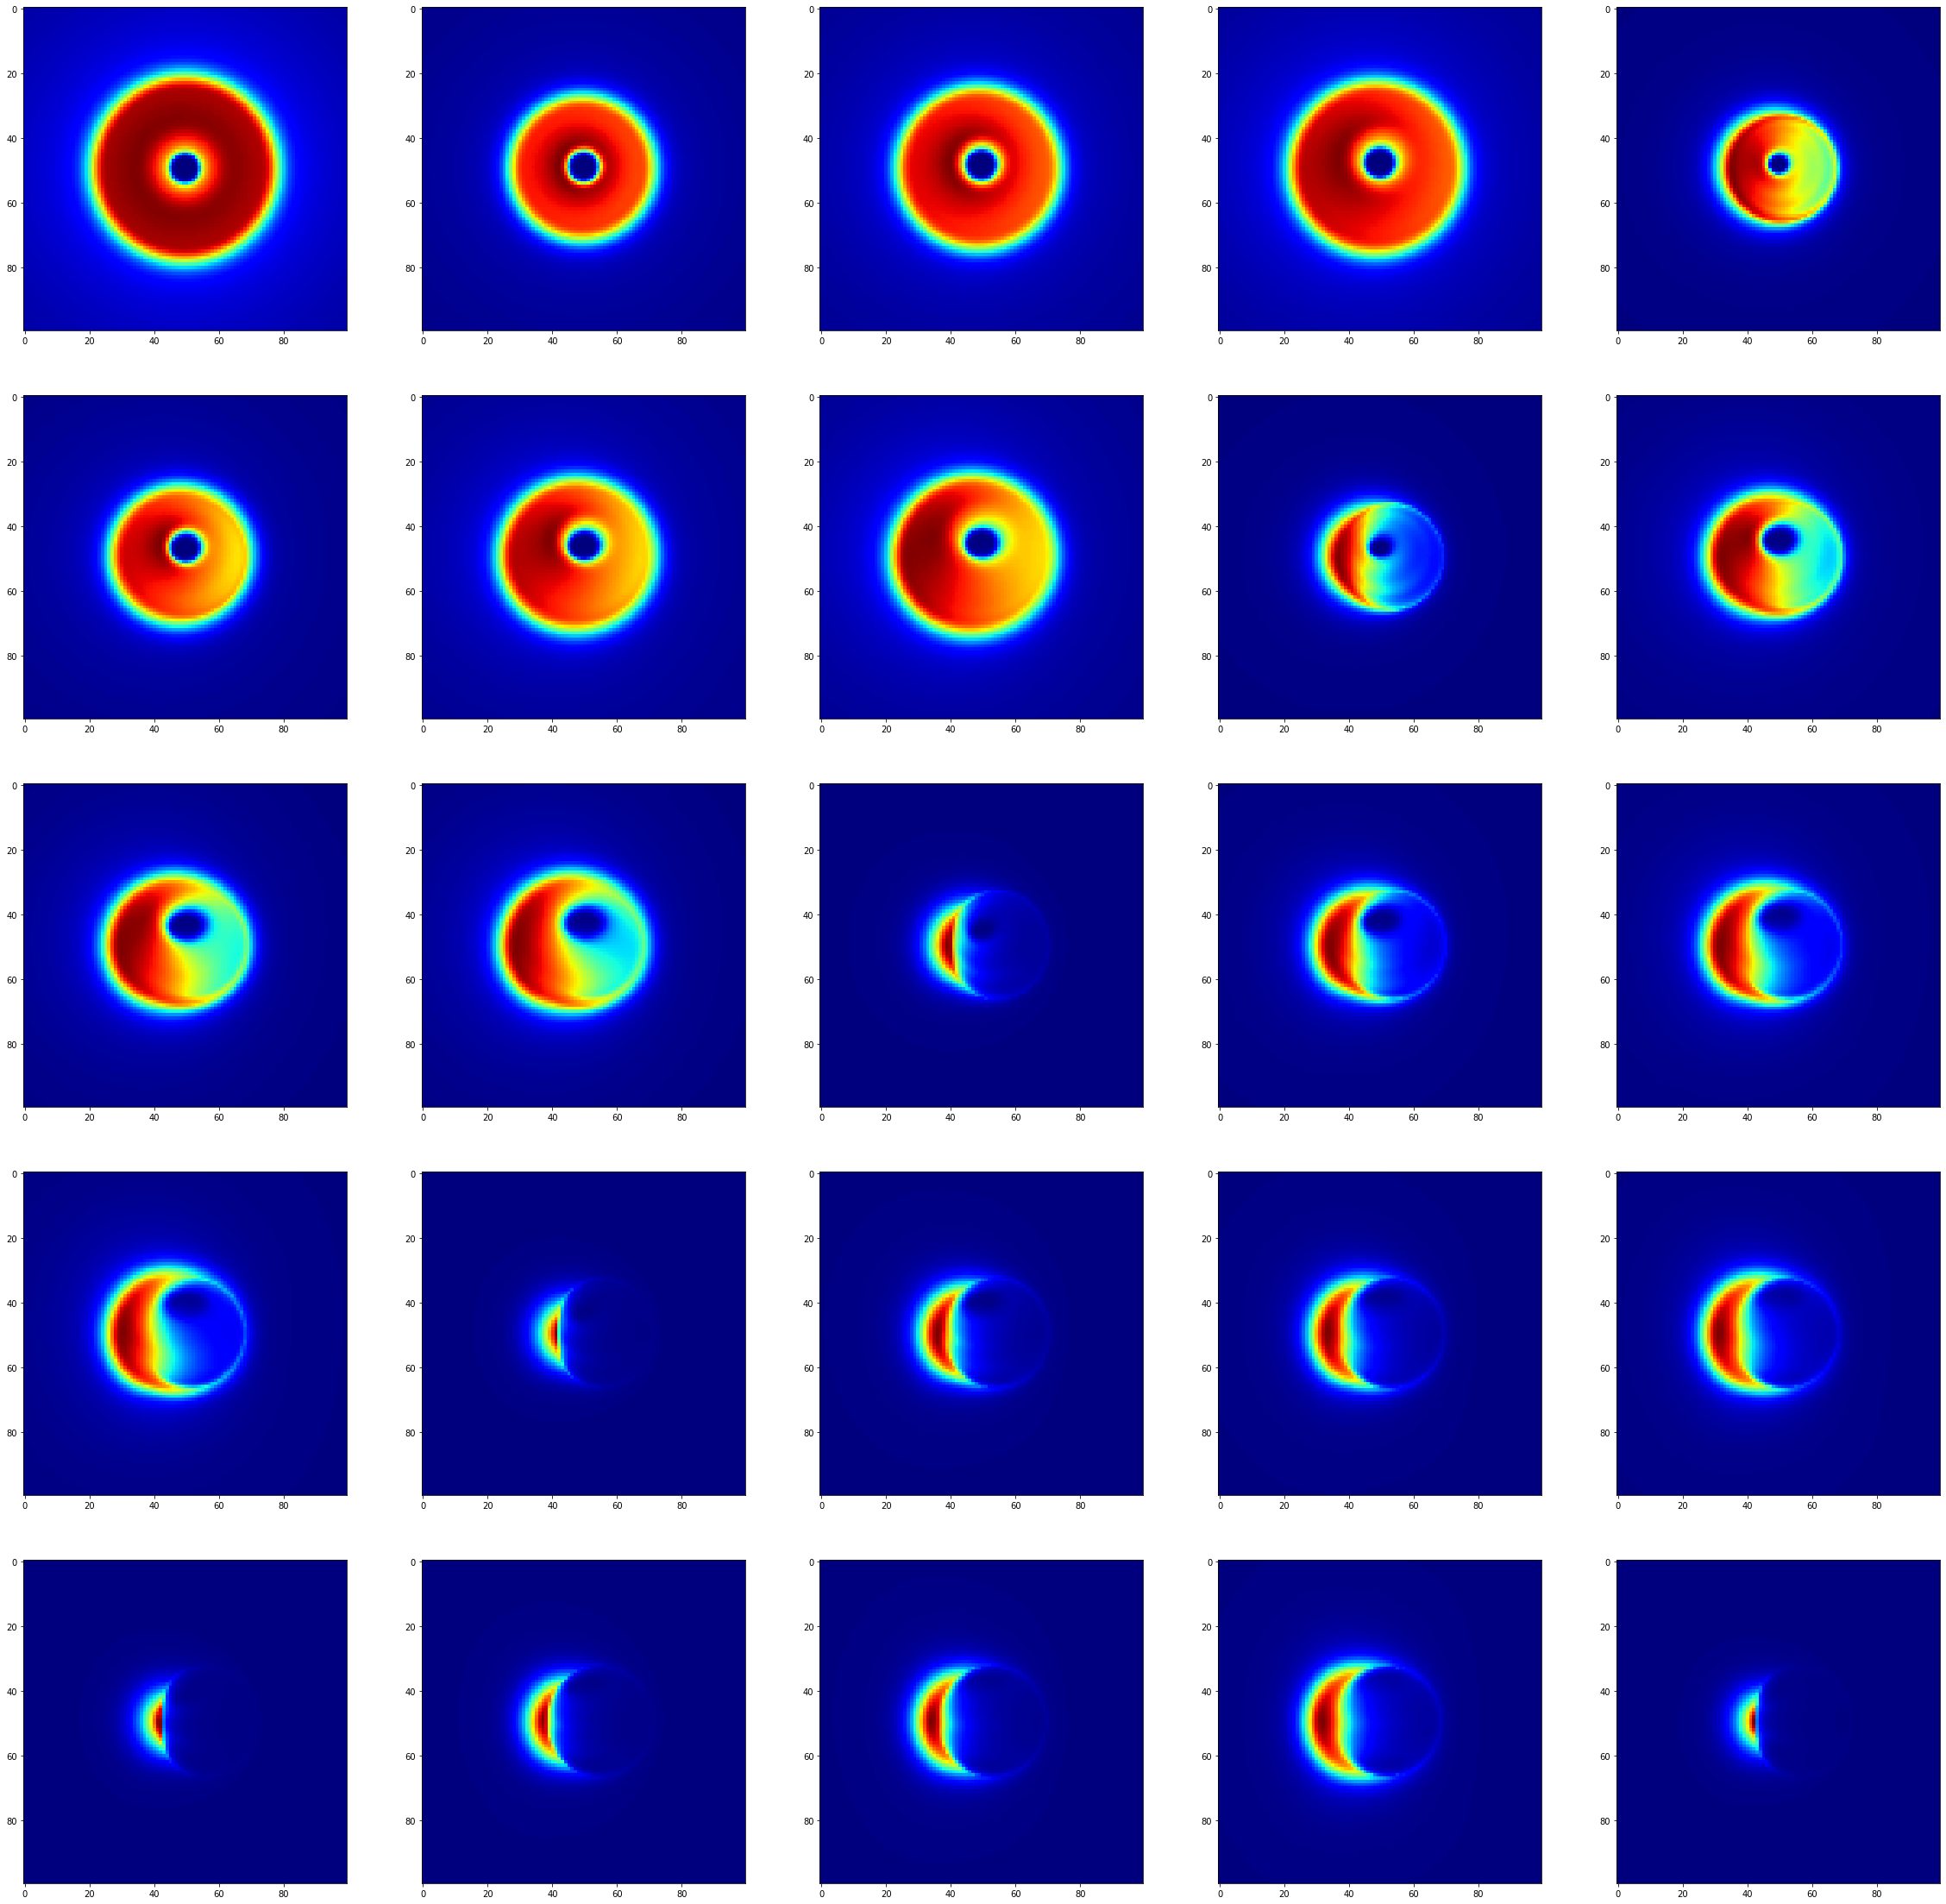

In [84]:
# from vis.visualization import visualize_saliency
plt.rcParams['figure.figsize'] = (40, 40)

idxs = [int(x) for x in np.linspace(0,9089, 25)]
for i, seed_idx in enumerate(idxs):
    ax1=plt.subplot(5, 5, i+1)
#     grads = visualize_saliency(model3, -1, filter_indices=0, seed_input=X[seed_idx])
    ax1.imshow(X[seed_idx].reshape(100,100), cmap='jet')
#     ax1.show()